In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.random.seed(69)

import multiprocessing
from multiprocessing import Pool
n_cores = multiprocessing.cpu_count()

import tqdm

from sklearn.decomposition import PCA

import helpers as h

In [6]:
movie_df = pd.read_csv('data/movies_c.txt', delimiter='\t', header=None,
                       names=["Movie Id", "Movie Title", "Unknown", "Action", 
                              "Adventure", "Animation", "Childrens", "Comedy", 
                              "Crime", "Documentary", "Drama", "Fantasy", 
                              "Film-Noir", "Horror", "Musical", "Mystery", 
                              "Romance", "Sci-Fi", "Thriller", "War", 
                              "Western"])

data_df = pd.read_csv('data/data_c.txt', delimiter='\t', header=None,
                      names=["User Id", "Movie Id", "Rating"])
train_df = pd.read_csv('data/train_c.txt', delimiter='\t', header=None,
                      names=["User Id", "Movie Id", "Rating"])
test_df = pd.read_csv('data/test_c.txt', delimiter='\t', header=None,
                      names=["User Id", "Movie Id", "Rating"])

## Helper Functions

In [7]:
def grad_A(Ai, Bj, Ui, Vj, mu, Yij, reg, eta):
    return eta * (reg * Ai - (Yij - mu - np.dot(Ui, Vj) - Ai - Bj))

def grad_B(Ai, Bj, Ui, Vj, mu, Yij, reg, eta):
    return eta * (reg * Bj - (Yij - mu - np.dot(Ui, Vj) - Ai - Bj))

def grad_U(Ai, Bj, Ui, Vj, mu, Yij, reg, eta):
    return eta * (reg * Ui - Vj * (Yij - mu - np.dot(Ui, Vj) - Ai - Bj)) 

def grad_V(Ai, Bj, Ui, Vj, mu, Yij, reg, eta):
    return eta * (reg * Vj - Ui * (Yij - mu - np.dot(Ui, Vj) - Ai - Bj)) 

def get_err(U, V, A, B, mu, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V, as well as user biases A, movie biases B, and
    overall offset mu.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T, 
    plus some bias terms.
    """
    predict = np.matmul(U, np.transpose(V))
    err = 0
    for (i, j , y_ij) in Y:
        err += (y_ij - mu - (predict[i][j] + A[i] + B[j]))**2
    return (reg/2 * ((np.linalg.norm(U))**2 + (np.linalg.norm(V))**2 + (np.linalg.norm(A))**2 + (np.linalg.norm(B))**2) 
            + 0.5 * err)/len(Y)

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300,
               desc='train_loop'):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    
    U = np.random.rand(M, K) - 0.5
    V = np.random.rand(N, K) - 0.5
    A = np.random.rand(M, 1) - 0.5
    B = np.random.rand(N, 1) - 0.5
    mu = np.mean(Y[:,2])
    old_loss = get_err(U, V, A, B, mu, Y, reg=reg)
    
    for e in tqdm.tqdm_notebook(range(max_epochs), desc=desc):
        Y_curr = Y[np.random.permutation(Y.shape[0])]
        for (i, j, y_ij) in Y_curr:
            gU = grad_U(A[i], B[j], U[i], V[j], mu, y_ij, reg, eta)
            gV = grad_V(A[i], B[j], U[i], V[j], mu, y_ij, reg, eta)
            gA = grad_A(A[i], B[j], U[i], V[j], mu, y_ij, reg, eta)
            gB = grad_B(A[i], B[j], U[i], V[j], mu, y_ij, reg, eta)
            U[i] -= gU
            V[j] -= gV
            A[i] -= gA
            B[j] -= gB
             
        new_loss = get_err(U, V, A, B, mu, Y, reg=reg)
        if e == 0:
            loss_delta = old_loss - new_loss
        if (old_loss - new_loss) / loss_delta <= eps:
            break
        old_loss = new_loss
        
    return (U, V, A, B, mu, get_err(U, V, A, B, mu, Y, reg=0.0))

## Grid Search Hyperpars

In [8]:
Y = train_df.values
Y_test = test_df.values
M = train_df["User Id"].values.ptp()  + 1
N = movie_df["Movie Id"].values.ptp() + 1

K = 20
etas = [0.01, 0.03, 0.1]
regs = [1e-4, 1e-2, 1e-3, 1e-1]
errs = np.empty((len(etas), len(regs)))

def train_func(hyperpars):
    eta, reg = hyperpars
    # This takes longer to run, so cap at 5 epochs
    U, V, A, B, mu, train_err = train_model(M, N, K, eta, reg, Y, desc=f'eta={eta}, reg={reg}', max_epochs=5)
    return get_err(U, V, A, B, mu, Y_test)
    
errs = [[train_func((eta, reg)) for reg in regs] for eta in etas]

## Final Training

In [10]:
Y = train_df.values
Y_test = test_df.values
M = train_df["User Id"].values.ptp()  + 1
N = movie_df["Movie Id"].values.ptp() + 1

K = 20; reg=0.1; eta=0.03 # Best grid search results
U, V, A, B, mu, train_err = train_model(M, N, K, eta, reg, Y, desc=f'all data')
test_err = get_err(U, V, A, B, mu, Y_test)
train_err, test_err

(array([0.26356471]), array([0.42178592]))

In [11]:
Y = data_df.values
M = train_df["User Id"].values.ptp()  + 1
N = movie_df["Movie Id"].values.ptp() + 1

K = 20; reg=0.1; eta=0.03
U, V, A, B, mu, err = train_model(M, N, K, eta, reg, Y, desc=f'all data')

## Plot Things

### Random Movies from some genres

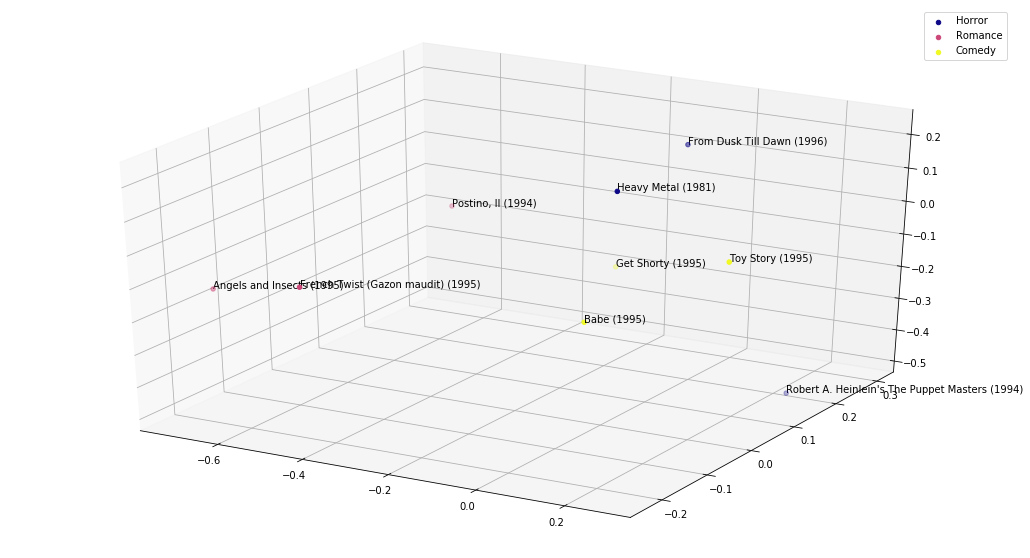

In [12]:
pca = PCA(3)
V_p = pca.fit_transform(V)
U_p = pca.transform(U)

genres = ["Horror", "Romance", "Comedy"]
n_mov = 3
h.plot_w_genre(genres, movie_df, V_p, n_mov=n_mov, dim_3=True)
plt.gcf().set_size_inches(18, 10)

### Most Pop / Best movies

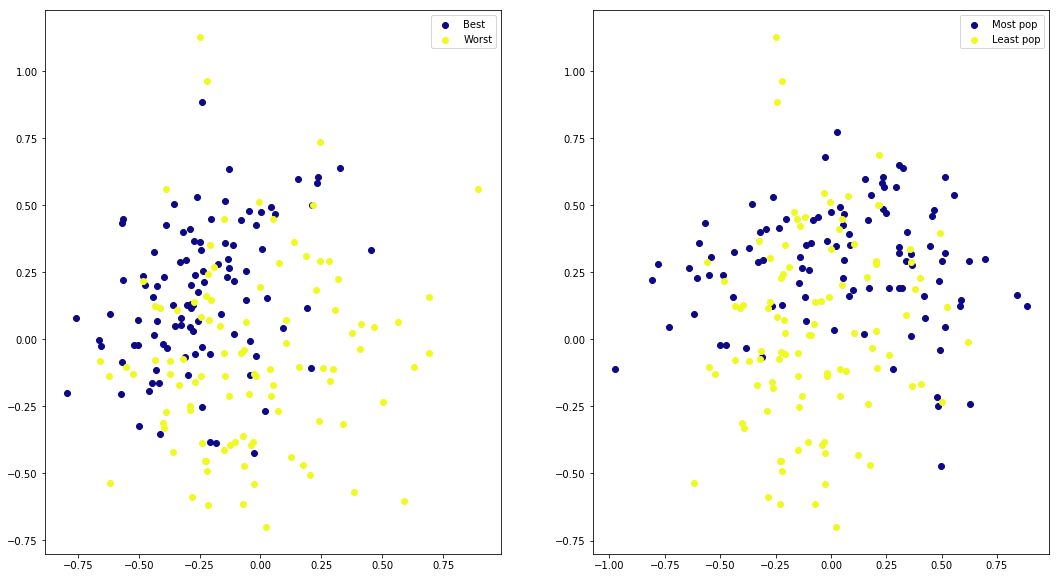

In [13]:
n_mov = 100
fig, ax = plt.subplots(1,2, figsize=(18, 10))
ids1 = [h.best_movs_ids(data_df, n_mov, get_worst=False),\
       h.best_movs_ids(data_df, n_mov, get_worst=True)]
ids2 = [h.pop_movs_ids(data_df, n_mov, get_least_pop=False),\
       h.pop_movs_ids(data_df, n_mov, get_least_pop=True)]
h.plot_w_ids(ids1, movie_df, V_p, labels=["Best", "Worst"], annotate=False, ax=ax[0])
h.plot_w_ids(ids2, movie_df, V_p, labels=["Most pop", "Least pop"], annotate=False, ax=ax[1])

### Genre reps plot

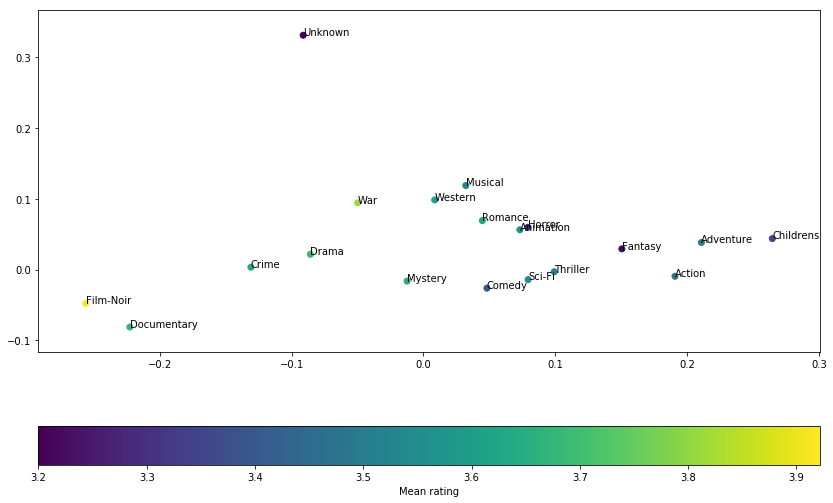

In [14]:
genres, ratings = h.get_genre_mean_ratings(data_df, movie_df)
ratings_dict = {g:r for g,r in zip(genres, ratings)}

genres, reps = h.get_genre_reps(V_p, movie_df)
repres = np.array(reps)
colors = np.array([ratings_dict[g] for g in genres])
sc = plt.scatter(repres[:, 0], repres[:, 1], c=colors)
for g, r in zip(genres, repres):
    plt.annotate(g, r[:2])
clb = plt.colorbar(sc, orientation='horizontal')
clb.set_clim(colors.min(), colors.max())
clb.set_label('Mean rating')
plt.gcf().set_size_inches(14, 9)

### 6 plots for spec

In [15]:
plt.gcf().set_size_inches(14, 9);
for i in range(1,7):
    h.six_plots(V_p, data_df, movie_df, which=i);
    plt.savefig(f'5b_{i}.png')
    plt.clf()

<Figure size 1008x648 with 0 Axes>